In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import peakutils as pk
import scipy.constants as const
from scipy.interpolate import interp1d
from scipy import signal
import pandas as pd
import itertools
from lmfit import Model

In [4]:
nist_argon_lines = [
    811.5311,
    763.5105,
    750.3869,
    738.3980,
    706.7217,
    696.5430,
    603.2127,
    912.2967
]

# Detector Calibration

Load the detector calibration curve from file

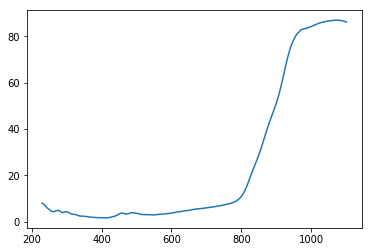

In [5]:
detector_calibration_curve = np.loadtxt('suspect_calibration_data/CalibrationFile.txt')
plt.plot(detector_calibration_curve[:,0], detector_calibration_curve[:,1])
plt.show()

Create interpolation object to resample to match the shape we need to correct our actual data

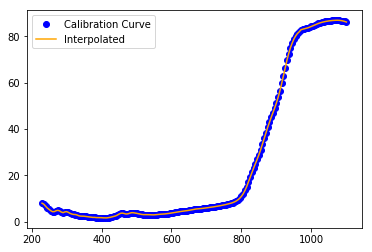

In [6]:
detector_calibration_curve_generated = interp1d(
    detector_calibration_curve[:,0],
    detector_calibration_curve[:,1]
)
plt.plot(detector_calibration_curve[:,0], detector_calibration_curve[:,1], "bo", label="Calibration Curve")
plt.plot(
    detector_calibration_curve[:,0],
    detector_calibration_curve_generated(detector_calibration_curve[:,0]), 
    "orange",
    label="Interpolated"
)
plt.legend(loc="upper left")
plt.show()

# Load some Argon data

In [7]:
filename = "data/20170721-Ar-Torch.txt"

In [8]:
data = np.loadtxt(filename, skiprows=14)
print(data.shape)

(2048, 2)


Cut off all values in file outside of the range of the calibration curve

In [9]:
pddata = pd.DataFrame(data, columns=['wavelength', 'intensity'], index=data[:,0])

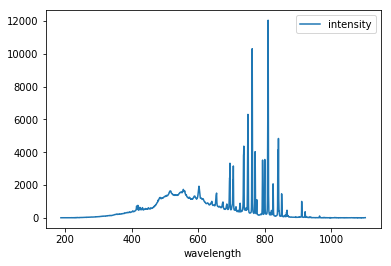

In [10]:
pddata.plot(x='wavelength', y='intensity')
plt.show()

In [11]:
pddata = pddata[250:1100]

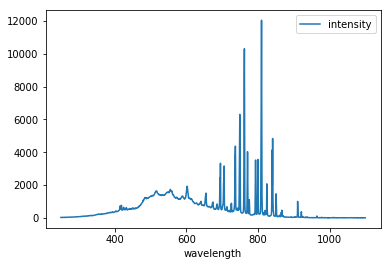

In [12]:
pddata.plot(x='wavelength', y='intensity')
plt.show()

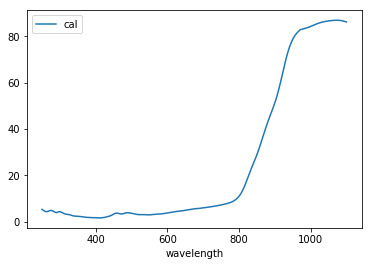

In [13]:
pddata['cal'] = detector_calibration_curve_generated(pddata['wavelength'])
pddata.plot(x='wavelength', y='cal')
plt.show()

In [14]:
pddata['corrected'] = pddata['intensity'] * pddata['cal']

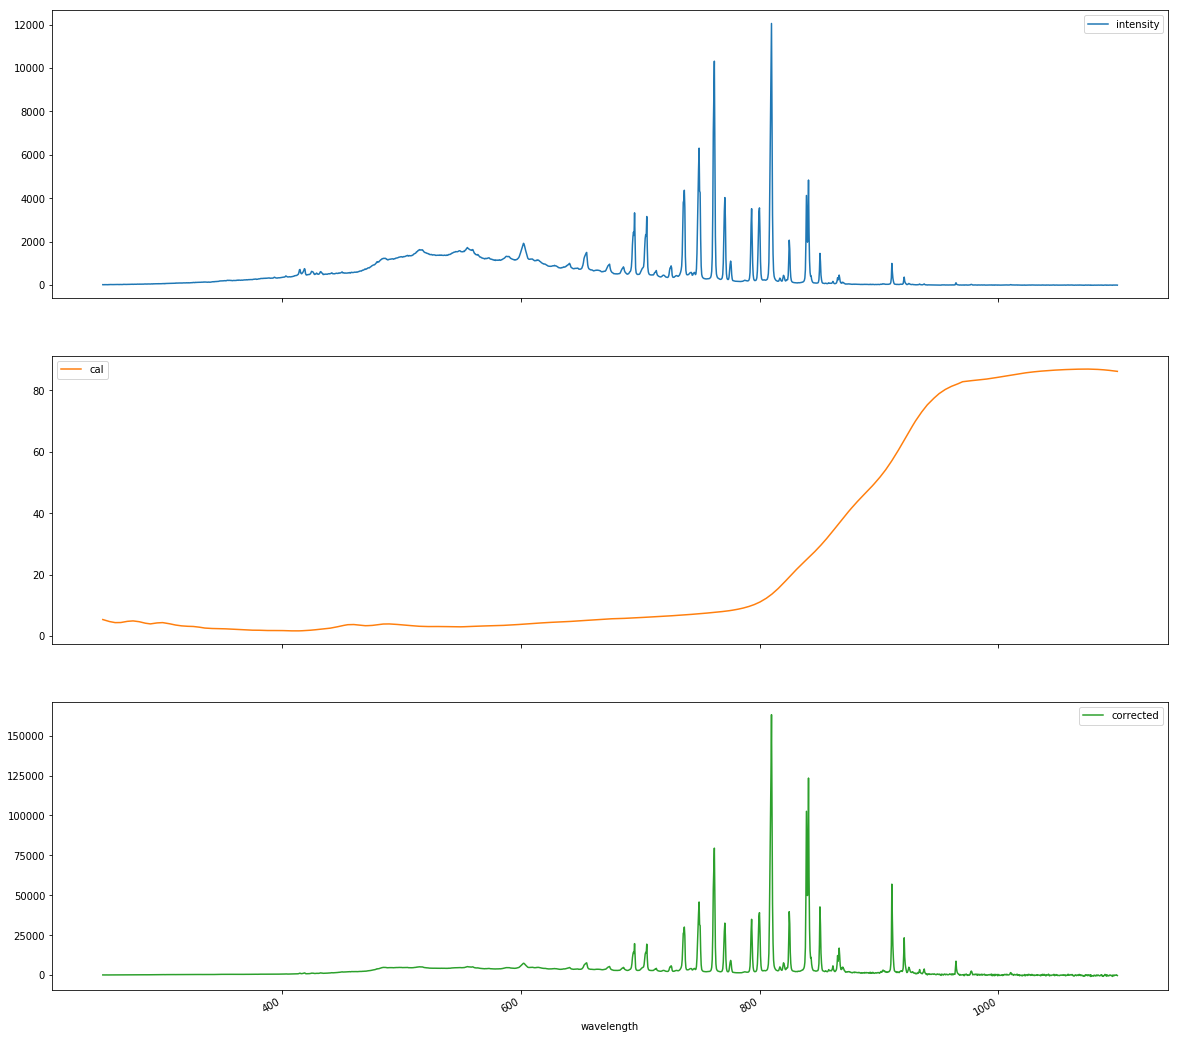

In [15]:
pddata.plot(x='wavelength', subplots=True, figsize=(20,20))
plt.show()

# Compare corrected spectrum to NIST peaks

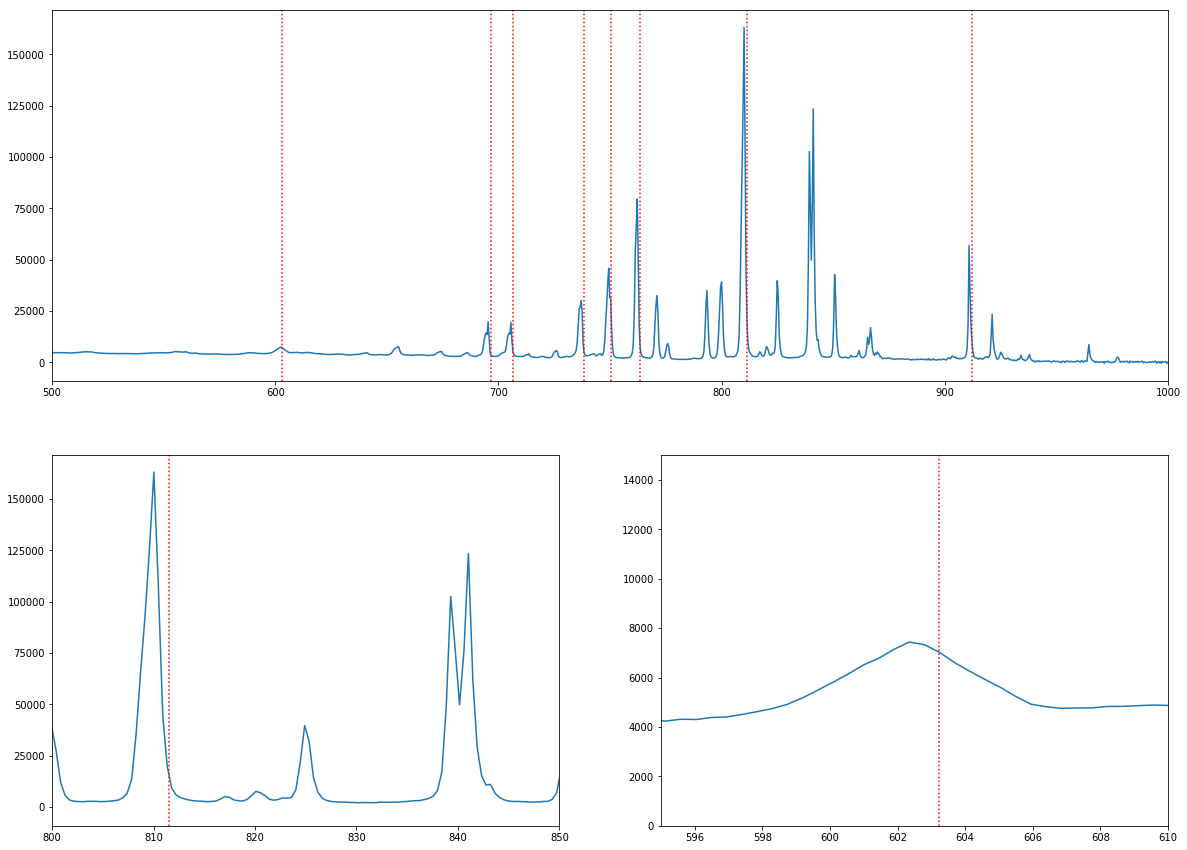

In [16]:
plt.figure(figsize=(20,15))

plt.subplot(2, 2, (1, 2))
plt.plot(pddata.wavelength, pddata.corrected)
for line in nist_argon_lines:
    plt.axvline(x=line, linestyle='dotted', color='red')
plt.xlim(500, 1000)

plt.subplot(2, 2, 3)
plt.plot(pddata.wavelength, pddata.corrected)
for line in nist_argon_lines:
    plt.axvline(x=line, linestyle='dotted', color='red')
plt.xlim(800, 850)

plt.subplot(2, 2, 4)
plt.plot(pddata.wavelength, pddata.corrected)
for line in nist_argon_lines:
    plt.axvline(x=line, linestyle='dotted', color='red')
plt.xlim(595, 610)
plt.ylim(0, 15000)

plt.show()

(690, 710)

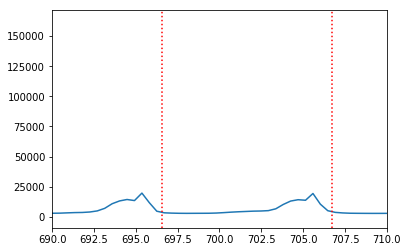

In [17]:
plt.plot(pddata.wavelength, pddata.corrected)
for line in nist_argon_lines:
    plt.axvline(x=line, linestyle='dotted', color='red')
plt.xlim(690, 710)

# Find the peaks

In [18]:
pddata.shape

(1911, 4)

In [19]:
peakind = signal.find_peaks_cwt(pddata.corrected, np.arange(1, pddata.shape[0]))

In [20]:
print(peakind)

[ 135  164  278  312  349  408  510 1234]


In [21]:
pddata.iloc[peakind]

,wavelength,intensity,cal,corrected
313.244,313.244,93.25,3.456271,322.297266
326.755,326.755,114.60,3.083383,353.355680
379.662,379.662,267.95,1.915126,513.157883
395.377,395.377,323.35,1.800315,582.131748
412.444,412.444,444.95,1.688252,751.187660
439.587,439.587,523.80,2.516880,1318.341498
486.299,486.299,1234.90,3.926782,4849.183218
810.035,810.035,12055.65,13.533010,163149.229595


(500, 1000)

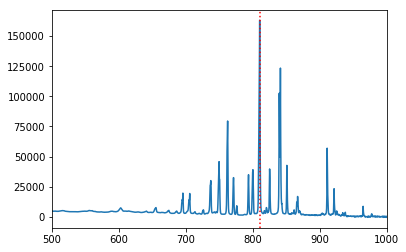

In [22]:
plt.plot(pddata.wavelength, pddata.corrected)
for line in pddata.iloc[peakind].wavelength:
    plt.axvline(x=line, linestyle='dotted', color='red')
plt.xlim(500, 1000)

## Let's try to use peakutils interpolation method, feeding it the indices from NIST

First we need to add the NIST wavelengths to the index

In [23]:
pddata.reset_index()
for l in nist_argon_lines:
    pddata.loc[l] = [l, None, None, None]

In [24]:
pddata.loc[pddata.wavelength.isin(nist_argon_lines)]

,wavelength,intensity,cal,corrected
811.5311,811.5311,NaN,NaN,NaN
763.5105,763.5105,NaN,NaN,NaN
750.3869,750.3869,NaN,NaN,NaN
738.3980,738.3980,NaN,NaN,NaN
706.7217,706.7217,NaN,NaN,NaN
696.5430,696.5430,NaN,NaN,NaN
603.2127,603.2127,NaN,NaN,NaN
912.2967,912.2967,NaN,NaN,NaN


In [25]:
pddata = pddata.interpolate(method='index')

In [26]:
pddata.loc[pddata.wavelength.isin(nist_argon_lines)]

,wavelength,intensity,cal,corrected
811.5311,811.5311,1107.602591,14.042103,15525.301546
763.5105,763.5105,894.219034,7.758293,6937.504913
750.3869,750.3869,3742.373605,7.292168,27284.176058
738.3980,738.3980,658.234729,6.925883,4558.686334
706.7217,706.7217,702.160169,6.160109,4324.864157
696.5430,696.5430,644.817753,5.949203,3835.690766
603.2127,603.2127,1809.808533,3.890214,7040.472373
912.2967,912.2967,144.626520,58.001142,8382.690304


Now use the peakutils interpolate function to fit gaussians near these values and return the best peaks

In [27]:
pddata = pddata.sort_values('wavelength')

In [28]:
index_list = [np.where(np.sort(pddata.wavelength.values) == n)[0].tolist()[0] for n in nist_argon_lines]
print(index_list)

[1244, 1134, 1103, 1075, 1002, 978, 768, 1477]


In [29]:
improved_peaks = pk.interpolate(x=pddata.wavelength.values, y=pddata.corrected.values, ind=index_list)
print(improved_peaks)

[809.82241265 761.94378556 749.3425358  736.67274515 704.93525111
 694.71944588 602.56211943 910.96926078]


In [30]:
pddata.reset_index()
for l in improved_peaks:
    pddata.loc[l] = [l, None, None, None]

In [31]:
pddata = pddata.sort_values('wavelength')

In [32]:
pddata = pddata.interpolate(method='index')

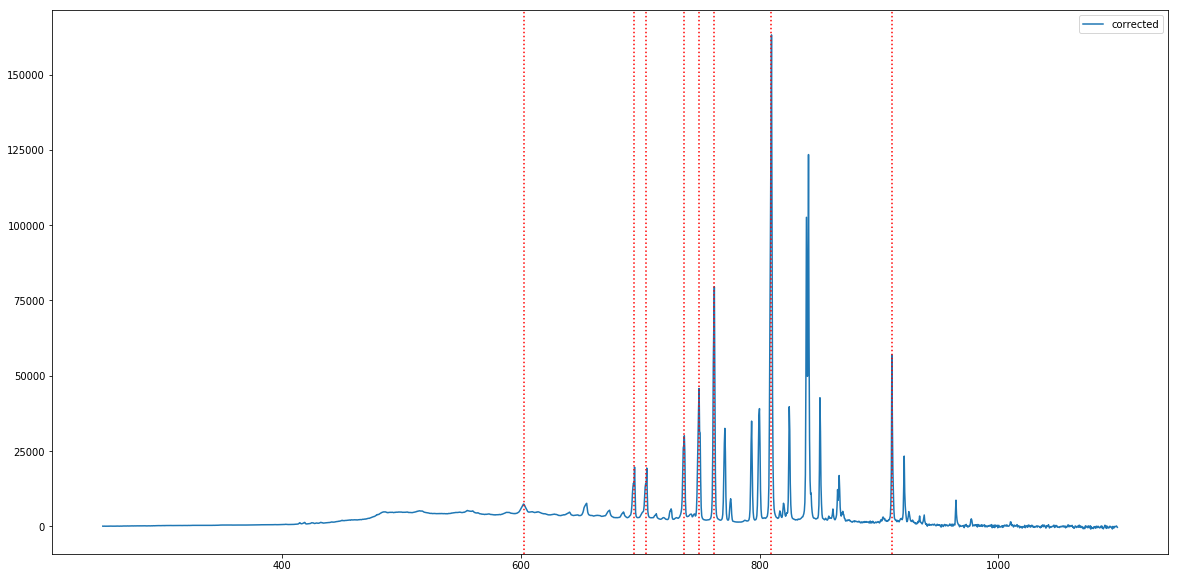

In [33]:
pddata.plot(y='corrected', figsize=(20,10))
for l in improved_peaks:
    plt.axvline(x=l, linestyle='dotted', color='red')
plt.show()

In [34]:
pddata.loc[improved_peaks]

,wavelength,intensity,cal,corrected
809.822413,809.822413,10752.193453,13.472231,144940.031457
761.943786,761.943786,9385.638735,7.699488,72271.707500
749.342536,749.342536,6189.970558,7.258179,44929.370262
736.672745,736.672745,3993.617357,6.877328,27466.290196
704.935251,704.935251,2284.731310,6.122308,13987.650751
694.719446,694.719446,2356.160477,5.912223,13929.807263
602.562119,602.562119,1906.993669,3.872652,7385.019743
910.969261,910.969261,870.273672,57.181315,49740.555531


In [35]:
peak_df = pddata.loc[improved_peaks]

In [36]:
nppeaks = peak_df[['wavelength', 'corrected']].values

In [37]:
print(nppeaks)

[[   809.82241265 144940.03145687]
 [   761.94378556  72271.70750038]
 [   749.3425358   44929.37026169]
 [   736.67274515  27466.29019585]
 [   704.93525111  13987.65075084]
 [   694.71944588  13929.8072625 ]
 [   602.56211943   7385.01974295]
 [   910.96926078  49740.55553117]]


# Now to use every combination of these peaks to fit a blackbody

Need to get:
- a list of every possible combination, length 2 to 9, of these points
- a blackbody function with intensity and wavelength to fit
- a goodness of fit value from each
- a temperature from each fit

## a list of every possible combination, length 2 to 9, of these points

In [38]:
pick_list = [[i for i in itertools.combinations(range(nppeaks.shape[0]), j)] for j in range(2, nppeaks.shape[0]+1)]

In [39]:
len(pick_list[0])

28

In [40]:
for c in pick_list[6][0]:
    print(nppeaks[c,:])

[   809.82241265 144940.03145687]
[  761.94378556 72271.70750038]
[  749.3425358  44929.37026169]
[  736.67274515 27466.29019585]
[  704.93525111 13987.65075084]
[  694.71944588 13929.8072625 ]
[ 602.56211943 7385.01974295]
[  910.96926078 49740.55553117]


In [41]:
len(pick_list[0])

28

In [42]:
pick_list[-1]

[(0, 1, 2, 3, 4, 5, 6, 7)]

# a blackbody function with intensity and wavelength to fit

In [43]:
def bb(wavelength, temperature=5000, intensity=1.0):
    """Intensity of black body radiation for a given wavelength
    
    Parameters
    ----------
    wavelength : float
        The input wavelength, expressed in nanometers. Can also be a numpy array.
    temperature : float
        Temperature of the black body, expressed in Kelvin.
    intensity : float, optional
        Converts from absolute to relative irradiance.
        
    Returns
    -------
    float
        The intensity of the black body curve at a given wavelength.
    """
    c = const.c
    h = const.Planck
    k = const.Boltzmann
    
    # convert from nanometers to meters
    l = wavelength * 1e-9
    
    fp = 2 * h * c ** 2 / l ** 5
    sp = np.exp(h * c / (l * k * temperature)) - 1
    
    return intensity * fp / sp

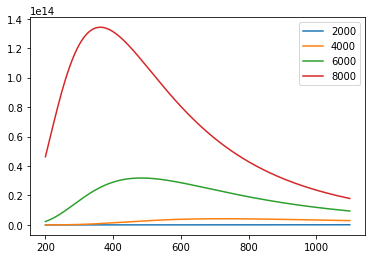

In [44]:
temperatures = [2000, 4000, 6000, 8000]
wavelengths = np.arange(200, 1100, 1)
for T in temperatures:
    plt.plot(wavelengths, bb(temperature=T, intensity=1, wavelength=wavelengths), label=T)

plt.legend(loc="upper right")
plt.show()

# Now do some model fitting!

## First figure out what this library does...

In [45]:
bbmodel = Model(bb)

In [46]:
bbmodel.param_names

['temperature', 'intensity']

In [47]:
bbmodel.independent_vars

['wavelength']

In [179]:
params = bbmodel.make_params(temperature=3800.0, intensity=5e-9)

In [180]:
params['temperature'].min = 200.0
params['temperature'].max = 12000.0
params['intensity'].min = 0.0

In [181]:
params

Parameters([('temperature',
             <Parameter 'temperature', 3800.0, bounds=[200.0:12000.0]>),
            ('intensity', <Parameter 'intensity', 5e-09, bounds=[0.0:inf]>)])

In [182]:
nppeaks[:,0]

array([809.82241265, 761.94378556, 749.3425358 , 736.67274515,
       704.93525111, 694.71944588, 602.56211943, 910.96926078])

In [183]:
nppeaks[:,1]

array([144940.03145687,  72271.70750038,  44929.37026169,  27466.29019585,
        13987.65075084,  13929.8072625 ,   7385.01974295,  49740.55553117])

In [184]:
result = bbmodel.fit(nppeaks[:,1], params, wavelength=nppeaks[:,0])

In [185]:
print(result.fit_report())

[[Model]]
    Model(bb)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18
    # data points      = 8
    # variables        = 2
    chi-square         = 1.5939e+10
    reduced chi-square = 2.6565e+09
    Akaike info crit   = 175.300623
    Bayesian info crit = 175.459506
[[Variables]]
    temperature:  4676.31077 +/- 0.00000000 (0.00%) (init = 3800)
    intensity:    5.0000e-09 +/- 0.00000000 (0.00%) (init = 5e-09)



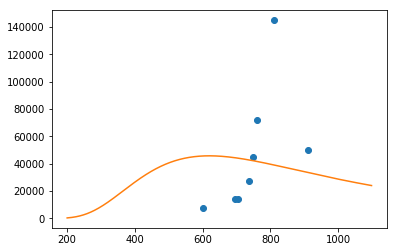

In [186]:
plt.plot(nppeaks[:,0], nppeaks[:,1], 'o')
plt.plot(wavelengths, result.eval(wavelength=wavelengths))
plt.show()

In [162]:
print(result.eval())

[1007.14804083 1212.84849873 1275.17882041 1341.76696751 1527.72364194
 1594.01702889 2374.68660745  695.65445713]


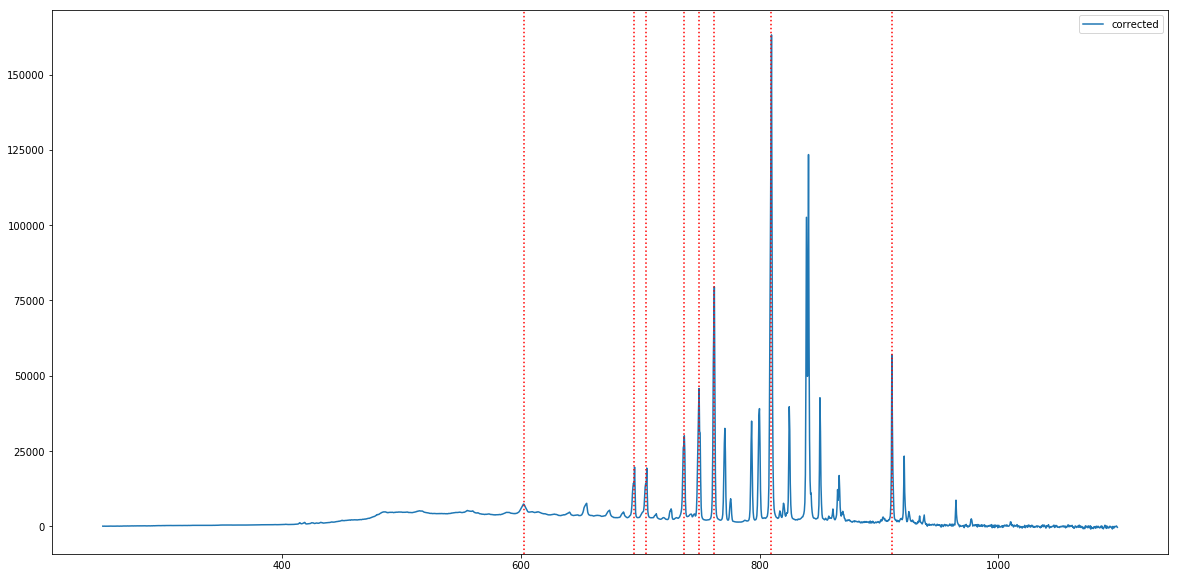

In [163]:
pddata.plot(y='corrected', figsize=(20,10))
for l in improved_peaks:
    plt.axvline(x=l, linestyle='dotted', color='red')
plt.show()

In [147]:
result.params.pretty_print()

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
intensity       1e-11        0      inf        0     True     None     None
temperature   1.2e+04     2000  1.2e+04        0     True     None     None


In [148]:
result.params.valuesdict()

OrderedDict([('temperature', 11999.999140702148),
             ('intensity', 1.000000082740371e-11)])

In [149]:
print(result.params.dumps())

{"unique_symbols": {"infty": Infinity, "None": null, "False": false, "temperature": 11999.999140702148, "NAN": NaN, "nan": NaN, "little_endian": true, "intensity": 1.000000082740371e-11, "newaxis": null, "e": 2.718281828459045, "Inf": Infinity, "pi": 3.141592653589793, "True": true, "inf": Infinity}, "params": [["temperature", 11999.999140702148, true, null, 2000, 12000, null, 0, null, 5000, null], ["intensity", 1.000000082740371e-11, true, null, 0, Infinity, null, 0, null, 1e-11, null]]}


In [150]:
result.params

Parameters([('temperature',
             <Parameter 'temperature', value=11999.999140702148 +/- 0, bounds=[2000:12000]>),
            ('intensity',
             <Parameter 'intensity', value=1.000000082740371e-11 +/- 0, bounds=[0:inf]>)])

In [151]:
result.params['temperature']

<Parameter 'temperature', value=11999.999140702148 +/- 0, bounds=[2000:12000]>

In [152]:
result.params['temperature'].value

11999.999140702148

In [153]:
result.params['temperature'].stderr

0

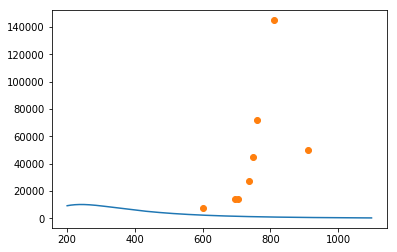

In [154]:
plt.plot(
    wavelengths, 
    bb(
        temperature=result.params['temperature'].value, 
        intensity=result.params['intensity'].value, 
        wavelength=wavelengths
    )
)
plt.plot(nppeaks[:,0], nppeaks[:,1], 'o')
plt.show()

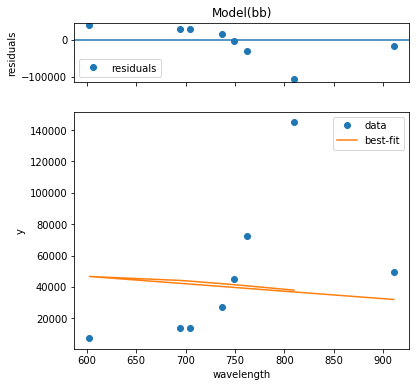

In [67]:
result.plot()
plt.show()

In [110]:
nppeaks[:,1]

array([144940.03145687,  72271.70750038,  44929.37026169,  27466.29019585,
        13987.65075084,  13929.8072625 ,   7385.01974295,  49740.55553117])

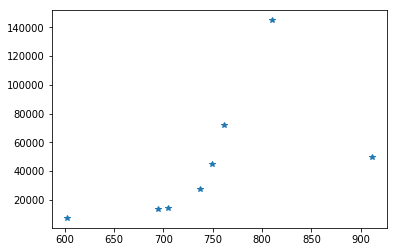

In [112]:
plt.plot(nppeaks[:,0], nppeaks[:,1], '*')
plt.show()

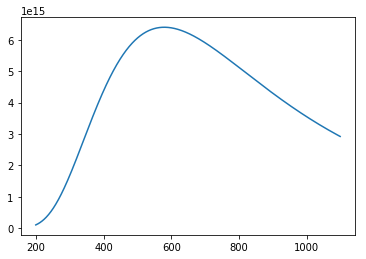

In [115]:
plt.plot(wavelengths, result.eval(wavelength=wavelengths))
plt.show()

In [187]:
calfile = np.loadtxt('suspect_calibration_data/20180220-BF-Calibration_OOIIrrad.cal', skiprows=9)

In [188]:
calfile.shape

(2048, 2)

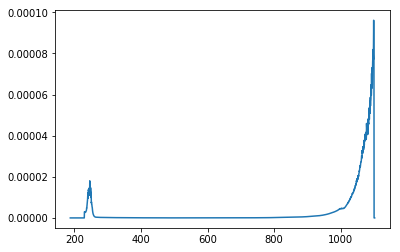

In [191]:
plt.plot(calfile[:,0], calfile[:,1])
plt.show()